In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from nca.utils import conv_same
import torchvision

In [5]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [6]:
def gif_from_pils(pils, fps):
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [7]:
def make_gif(nca_out, fps=10, size=(500, 500)):
    nca_out = torch.pow(nca_out, 1)
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize(size, Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [71]:
class SimpleNCA(nn.Module):
    def __init__(self, msg_size) -> None:
        super().__init__()
        perc = 30
        hid = 10

        self.msg_size = msg_size
        self.kernel = nn.Sequential(
            conv_same(msg_size, perc, ks=5, padding_mode="zeros", bias=True),
            nn.ReLU(),
            conv_same(perc, perc, ks=3, padding_mode="zeros", bias=True),
            nn.ReLU(),
        )

        self.rule = nn.Sequential(
            conv_same(perc, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, 1, ks=1, bias=True),
        )

        for p in self.kernel.parameters():
            nn.init.uniform_(p, -1, 1)
        for p in list(self.rule.parameters()):
            nn.init.uniform_(p, -0.2, 0.2)
        nn.init.zeros_(self.rule[-1].bias)
        
        self.optim = torch.optim.Adam(self.parameters(), lr=0.001)

    def optim_step(self, bs, im_size, steps):
        msg = torch.rand(bs, self.msg_size)
        screen = torch.zeros(bs, 1, im_size, im_size)
        screen[:, 1, im_size // 2:im_size // 2 + 1, im_size // 2:im_size // 2 + 1] = msg
        
    def get_

    def forward(self, x, steps):
        seq = [x]
        dt = 1
        for i in range(steps):
            perc = self.kernel(x)
            y = self.rule(perc)
            x = torch.clamp(x + dt * y, 0, 1)
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [72]:
msg_size = 16
nca = SimpleNCA(msg_size=msg_size)

inp = torch.zeros(3, 16, 32, 32)
inp[:, :, 16:17, 16:17] = 1
out = nca(inp, steps=50)


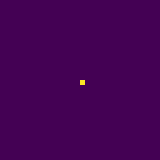

In [62]:
make_gif(out[1,:,0], size=(32 * 5, 32 * 5))

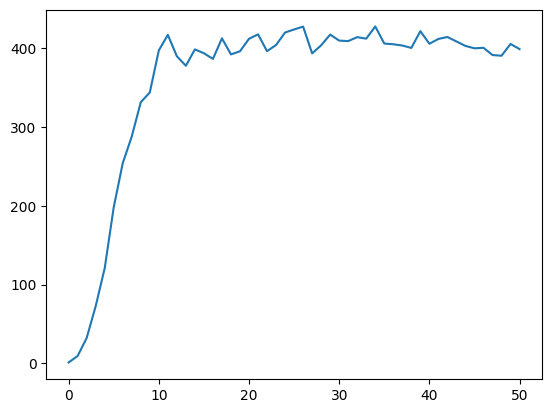

In [63]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
plt.plot(vals)